# 뉴스 요약봇 만들기 프로젝트

In [1]:
# !pip3 install summa

import nltk
import tensorflow
import summa
import pandas as pd

nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers import AdditiveAttention

from summa.summarizer import summarize


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 함수 및 변수 정의

In [2]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


# 짧은 문장 체크
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

# 희귀 단어 관련 체크 함수
def check_words_threshold(tokenizer,threshold):
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0 and i!=tar_word_to_index['sostoken'] and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i]+' '
    return temp



## 데이터 수집


In [3]:
# sample 파일 다운로드
# import urllib.request
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
52059,PM Modi has become a symbol of grand failure: ...,Speaking at a literature festival organised by...
40999,Goldman Sachs moves tribunal to recover Ã¢ÂÂ¹...,Goldman Sachs has approached the National Comp...
23032,Ishant Sharma fined 15% match fee for Malan se...,Indian fast bowler Ishant Sharma has been fine...
37613,India ensured Maldives lost UN Security Counci...,India did not vote in favour of the Maldives f...
24392,FB to open startup incubator in China despite ...,Facebook has obtained a licence to set up a st...
17790,Vicky Kaushal gets hand-written letter from Bi...,Actor Vicky Kaushal took to Twitter to share a...
66960,Akshay deletes tweet on manual scavengers afte...,Akshay Kumar deleted his tweet in which he cal...
65602,Aamir Khan fails to name Indian women's cricke...,Bollywood actor Aamir Khan failed to answer wh...
66944,Tax rebate scrapped for Mumbai houses followin...,The Brihanmumbai Municipal Corporation (BMC) h...
92012,I can be 50 times more brutal than terrorists:...,Philippines President Rodrigo Duterte has warn...


## 데이터 전처리 ( 추상적 요약 )

In [4]:
# 중복 확인
print('전체 샘플수 :', (len(data)))
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

#결측치 확인
data.isnull().sum()

전체 샘플수 : 98401
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


headlines    0
text         0
dtype: int64

In [5]:
# 중복제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98262
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [7]:
# 정규화 사전 준비
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [9]:
# 전처리 함수 적용
data['headlines'] = [preprocess_sentence(sentence, remove_stopwords=False) for sentence in data['headlines']]
data['text'] = [preprocess_sentence(sentence) for sentence in data['text']]

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()

#data.dropna(axis=0, inplace=True)
#print('전체 샘플수 :', (len(data)))

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


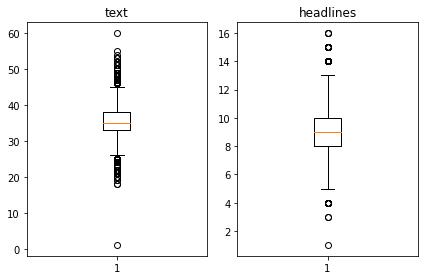

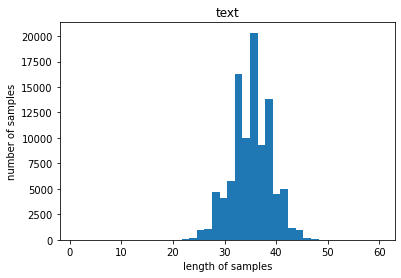

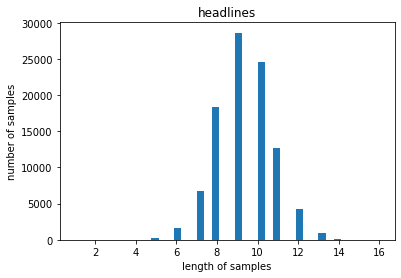

In [10]:
# 문장 길이 시각화 확인
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
# 최대 길이

text_max_len = 43
headlines_max_len = 12

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 43 이하인 샘플의 비율: 0.9871797478649857
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [12]:
data = data[(data['text'].str.split().str.len() <= text_max_len) &
            (data['headlines'].str.split().str.len() <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95935


In [13]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

# numppy 타입 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [14]:
#데이터 랜덤 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


#데이터 비율 8:2 훈련 테스트 데이터 나누기
n_of_val = int(len(encoder_input)*0.2)
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))


훈련 데이터의 개수 : 76748
훈련 레이블의 개수 : 76748
테스트 데이터의 개수 : 19187
테스트 레이블의 개수 : 19187


In [15]:
# 인코더 데이터 토크나이징
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
# 단어 빈도 확인
check_words_threshold(src_tokenizer,7)

단어 집합(vocabulary)의 크기 : 68509
등장 빈도가 6번 이하인 희귀 단어의 수: 46638
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21871
단어 집합에서 희귀 단어의 비율: 68.07572727670816
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.525585266153003


In [16]:
# 인코더 vocab 크기 제한
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[63, 1953, 62, 6964, 245, 88, 52, 223, 258, 7340, 9, 385, 73, 505, 258, 7340, 84, 139, 74, 230, 63, 2307, 3724, 467, 267, 229, 11971, 505, 691, 258, 7340], [309, 3357, 11086, 2323, 7341, 260, 2525, 19191, 9479, 1419, 392, 4135, 7341, 6025, 7050, 1151, 2578, 4135, 8410, 2579, 7050, 4135, 5482, 69, 616, 1141, 31, 19192, 574, 7341, 2456, 7050, 479], [11348, 1508, 1480, 412, 886, 75, 2377, 3430, 597, 6347, 1211, 1608, 22, 458, 18110, 343, 1508, 3795, 303, 322, 1312, 303, 14564, 1798, 8272, 2355, 120, 762, 1819, 2580, 27, 303, 101, 418]]


In [17]:
# 디코더 데이터 토크나이징
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
# 단어 빈도 확인
check_words_threshold(tar_tokenizer,6)


단어 집합(vocabulary)의 크기 : 29672
등장 빈도가 5번 이하인 희귀 단어의 수: 19409
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10263
단어 집합에서 희귀 단어의 비율: 65.41183607441359
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.75107944402911


In [18]:
# 디코더 vocab 크기 제한
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])


input
input  [[1, 35, 179, 10, 106, 171, 16, 361, 4775, 4, 3825], [1, 6402, 930, 598, 4612, 525, 10, 3261, 69, 4462], [1, 531, 1220, 3, 157, 1993, 1150, 3, 3532, 322, 62], [1, 266, 7, 532, 1084, 380, 5341, 127, 678, 130], [1, 39, 26, 3113, 427, 3826, 10, 1632, 3442]]
target
decoder  [[35, 179, 10, 106, 171, 16, 361, 4775, 4, 3825, 2], [6402, 930, 598, 4612, 525, 10, 3261, 69, 4462, 2], [531, 1220, 3, 157, 1993, 1150, 3, 3532, 322, 62, 2], [266, 7, 532, 1084, 380, 5341, 127, 678, 130, 2], [39, 26, 3113, 427, 3826, 10, 1632, 3442, 2]]


In [19]:
# SOS, EOS 만 남은 데이터 제거
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76747
훈련 레이블의 개수 : 76747
테스트 데이터의 개수 : 19187
테스트 레이블의 개수 : 19187


In [20]:
# 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 모델 설계( 추상적 요약 )
### 인코더

In [21]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

### 디코더 ( 어텐션 매커니즘 적용 )

In [22]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])


# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 모델 훈련( 추상적 요약 )

In [23]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
300/300 [==============================] - 84s 99ms/step - loss: 5.6225 - val_loss: 5.2134
Epoch 2/50
300/300 [==============================] - 30s 101ms/step - loss: 5.0445 - val_loss: 4.8243
Epoch 3/50
300/300 [==============================] - 33s 110ms/step - loss: 4.6949 - val_loss: 4.5659
Epoch 4/50
300/300 [==============================] - 32s 107ms/step - loss: 4.4264 - val_loss: 4.3749
Epoch 5/50
300/300 [==============================] - 32s 107ms/step - loss: 4.2272 - val_loss: 4.2408
Epoch 6/50
300/300 [==============================] - 33s 108ms/step - loss: 4.0641 - val_loss: 4.1418
Epoch 7/50
300/300 [==============================] - 32s 107ms/step - loss: 3.9219 - val_loss: 4.0545
Epoch 8/50
300/300 [==============================] - 32s 108ms/step - loss: 3.7965 - val_loss: 3.9825
Epoch 9/50
300/300 [==============================] - 33s 108ms/step - loss: 3.6829 - val_loss: 3.9264
Epoch 10/50
300/300 [==============================] - 32s 108ms/step - lo

<function matplotlib.pyplot.show(close=None, block=None)>

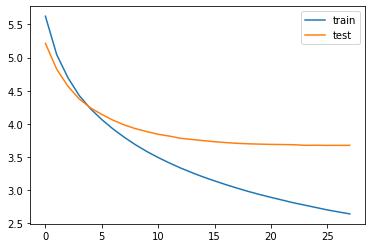

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show


## 인퍼런스 모델 구현( 추상적 요약 )

In [25]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


### 인코더

In [26]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


### 디코더

In [27]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


### 결과 확인

- 전처리에 의해 문장이 어색해진 것에 비하면 문법적으로는 읽어지는 수준의 요약을 보여준다
- 하지만 의미상으로 실제 요약보다는 많이 떨어져보임

In [117]:
# 추상적 요약 결과 확인
import random
# 랜덤 샘플링을 위한 고유한 인덱스를 5개 생성
sampled_indices = random.sample(range(len(decoder_input_test)), 5)

for i in sampled_indices:
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : year old girl allegedly gangraped two days ago medical test yet non availability doctors government hospital ghaziabad two minors detained connection case also awaiting medical tests victim playing accused took secluded spot raped 
실제 요약 : rape victim medical test delayed over absence of doctors 
예측 요약 :  year old girl raped by in delhi


원문 : united states president donald trump themed ecstasy pills sold united kingdom tagline trump makes partying great pills pink orange coloured shape head face people reportedly said going pill describing quality orange donald trump tablets 
실제 요약 : tablets shaped like trump head being sold in uk 
예측 요약 :  trump mistakenly sold for lakh


원문 : priyanka chopra production based rabindranath tagore love story barred shooting campus bharati university objection focussing love life said vice chancellor kali sen however film director chatterjee claimed former vice chancellor kumar datta gave permission december last year 
실제 요약 : priyanka film barred 

## 추출적 요약 ( Summa 이용 )

- Summa의 경우 문장 단위로만 요약이 되는 것으로 보인다.
- 반환할 문장보다 요구되는 길이가 짧은 경우 요약을 반환하지 않음
- 중요 문장을 선택해 나열하는 수준의 요약으로 보인다.

In [142]:
home = os.getenv('HOME')
path = os.path.join(home, 'President Has Mulled Powell Fate for Months.txt')
with open(path, encoding = 'UTF-8') as f:
    text = f.read()

# 50단어 요약
print(summarize(text, words=50))

In meetings at the president's private Florida club, Mar-a-Lago, Trump has spoken with Kevin Warsh, a former Fed governor, about potentially firing Powell before his term ends and possibly selecting Warsh to be his replacement, the people said.
Trump interviewed Warsh for the Fed chair job in 2017 before choosing Powell, who became chair the following year.


In [138]:
# 10% 요약
print(summarize(text, ratio=0.1))

WASHINGTON -- President Trump has for months privately discussed firing Federal Reserve Chair Jerome Powell, according to people familiar with the matter, but he hasn't made a final decision about whether to try to oust him before his term ends next year.
In meetings at the president's private Florida club, Mar-a-Lago, Trump has spoken with Kevin Warsh, a former Fed governor, about potentially firing Powell before his term ends and possibly selecting Warsh to be his replacement, the people said.
Still, any argument against firing Powell hasn't stopped Trump from making the case to allies in private meetings that the Fed chair should lose his job and that the Fed's governing law, which says policymakers can only be removed "for cause," isn't strong enough to hold up in court if he sought to remove Powell.
Powell said Wednesday he didn't think that legal challenge, which concerns Trump's removal of a member of the National Labor Relations Board, would ultimately apply to the Fed -- presu

### 비교용 AI 요약본

#### AI 두문장 요약
Former President Trump has privately discussed firing Federal Reserve Chair Jerome Powell before his term ends, though no final decision has been made. Legal and political challenges, along with internal disagreement among Trump's advisers, make such a move highly uncertain and potentially destabilizing.

#### AI 10% 요약
Former President Trump has repeatedly discussed firing Federal Reserve Chair Jerome Powell before his term ends, frustrated by what he sees as Powell’s failure to cut interest rates quickly enough. Though Trump believes he has the authority to remove Powell, legal precedent, internal divisions among his advisers, and concerns about undermining the Fed’s independence have so far prevented action. Some advisers, including Treasury Secretary Scott Bessent and Kevin Warsh, whom Trump has considered as a potential replacement, have cautioned against the move due to potential market instability and legal challenges. The issue is further complicated by the Supreme Court’s possible reconsideration of the 1935 "Humphrey’s Executor" decision, which limits a president’s ability to remove independent agency officials.



## 분석 ( 추상적 요약 추출적 요약 비교 )

| 비교 항목             | 추상적 요약                        | 추출적 요약                        |
|------------------------|-------------------------------------|-------------------------------------|
| 문법 완성도         | 자연스럽다고까지 할 순 없으나 문법에 맞는 경우가 많다        | 문장자체를 가져와서 문장의 문법은 이상없었으나 문장 사이를 연결하는 조사등이 어색한 경우가 있음  |
| 핵심 단어 포함 여부 | 일부 누락되거나 유사어로 대체되는 경우가 있다        | 핵심 문장자체를 포함       |
| 문장 단어 연결 흐름 | 대체적으로 자연스러운 경우가 많음          | 연속된 문장이 선택된 경우가 아니면 연결 흐름이 이상하다.  |
| 문장 중복 여부      | 중복된 의미의 문장은 사용되지 않는 것으로 보임        | 비슷한 의미의 문장이 다시 출현하는 경우가 있음 |
| 문장 길이    | 알아서 적절한 길이로 요약      | 원문 문장 길이에 따라 요약 한계 존재하는 것으로 보임(어느정도 길이 이하의 요약 생성 안됨)  |

In [ ]:
# Summ 요약및 비교 확인을 위해 데이터 원본 준비
# 모델을 재훈련하는데 시간이 많이 들어 data를 추가로 읽어들여 처리

#import urllib.request
#urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_ori = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
# 중복제거
data_ori.drop_duplicates(subset = ['text'], inplace=True)

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)


In [121]:
import random
# 랜덤 샘플링을 위한 고유한 인덱스를 10개 생성
sampled_indices = random.sample(range(len(decoder_input_test)), 10)

for idx in sampled_indices:
    # decoder_input_test에서 인덱스에 해당하는 텍스트 추출
    decoder_input = decoder_input_test[idx]
    
    # decoder_input을 seq2headlines로 변환하여 예측된 요약 생성
    pre_headlines = seq2headlines(decoder_input).strip()
    
 
    # data_ori에서 headline 컬럼이 decoder_input과 같은 값을 가진 원본 데이터를 찾기
    matching_index = data[data['headlines'] == pre_headlines].index

    matching_rows = data_ori.loc[matching_index]
   
    # matching_rows가 하나만 존재할 경우에만 처리
    if len(matching_rows) != 1:
        continue  # 하나의 값만 존재하지 않으면 건너뛰기
    # 원문과 실제 요약 출력
    print("원문 (기사)    : "+str(matching_rows['text'].values[0]))
    print("원문 (헤드라인): ",str(matching_rows['headlines'].values[0]))
    print("\n")
    print("전처리된 원문  : "+seq2text(encoder_input_test[idx]))
    print("전처리된 헤드라인 : ", pre_headlines)
    print("추상 요약(어텐션) : ", decode_sequence(encoder_input_test[idx].reshape(1, text_max_len)))
    print("추출 요약(Summ10%): ", summarize(str(matching_rows['text'].values[0]), ratio=0.1))
    print("추출 요약(Summ40%): ", summarize(str(matching_rows['text'].values[0]), ratio=0.4))
    print("\n"+"="*80+"\n")


원문 (기사)    : A Gurugram court on Monday sentenced a lawyer to three years in jail for cheating his handicapped client in 2008. Out of a compensation of Ã¢ÂÂ¹5.63 lakh awarded to the victim in a case, the lawyer usurped Ã¢ÂÂ¹2 lakh using fraudulent means. The court said the punishment was necessary as his actions could shake people's faith in the legal system.
원문 (헤드라인):  Lawyer jailed for 3 years for cheating client in Gurugram


전처리된 원문  : gurugram court monday sentenced lawyer three years jail cheating handicapped client compensation lakh awarded victim case lawyer lakh using fraudulent means court said punishment necessary actions could shake people faith legal system 
전처리된 헤드라인 :  lawyer jailed for years for cheating client in gurugram
추상 요약(어텐션) :   man sentenced to life term for years in jail
추출 요약(Summ10%):  
추출 요약(Summ40%):  A Gurugram court on Monday sentenced a lawyer to three years in jail for cheating his handicapped client in 2008.


원문 (기사)    : Former Indian all-rounde

## 회고
추상적 요약과 추출적 요약에 대해서 조금은 알수 있게 되었다. 그리고 컴퓨팅 자원의 소중함을 느낀다. 클라우드에서 계속 되지 않아서 코랩으로 작성하고 그러다 몇번 끊어지고 다시 돌리다보니 리소스가 끝나있고 로컬 환경을 구축해야겠다는 생각을 했다. 그리고 데이터 원본을 잘 저장하고 원본을 다시 잘 찾을 수 있도록 인덱스나 매핑 관리는 잘해야겠다고 느꼈다. 아직 기초적인 수준의 내용을 적용한 것이라 그런지 생성형 AI의 요약과는 많은 차이가 있었다. 개선점을 더 고민해봐야하지만 시간상 할 수 없었다. 텍스트를 다루게 된다면 어떤 점을 고민하고 공부해야될 것인가에 대해서 생각을 해봐야할 것 같다. 다하고 든 생각인데 모델이 과적합된 것은 아닐까 생각해보게된다 10번 이내로 돌렸을때의 결과를 확인해보고싶지만 시간이 너무 많이 든다. 이렇게 적어두고 나중에 시간이 있을때 해봐야겠다.